In [18]:
%matplotlib inline

import os
import shutil
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from nltools.data import Brain_Data, Design_Matrix, Adjacency
from nltools.mask import expand_mask, roi_to_brain
from nltools.stats import regress, zscore, fdr, one_sample_permutation, find_spikes
from nltools.external import glover_hrf
from nilearn.plotting import view_img, glass_brain, plot_stat_map
from sklearn.metrics import pairwise_distances
from scipy.stats import binom, ttest_1samp
import networkx as nx
from numpy import sin, pi, arange
from numpy.fft import fft, ifft
from scipy.signal import butter, filtfilt, freqz

netid = 'f00275v'
base_dir = '/dartfs/rc/lab/P/Psych60/'
# base_dir = '/Volumes/Psych60/'
output_dir = os.path.join(base_dir, 'students_output', netid)
data_dir = os.path.join(base_dir, 'data',)
dat_dir = '/dartfs/rc/lab/D/DBIC/cosanlab/datax/Projects/trust/DS121/SUBJECTS'

In [13]:
data_name = 'DS121'
os.mkdir(os.path.join(data_dir, data_name))

In [15]:
data_name = 'DS121'
data_dir = os.path.join(base_dir, 'data', data_name)

file_list = glob.glob(os.path.join(dat_dir, '*','FUNCTIONAL','s*nii'))
sub_list = list(set([f.split('/')[-3] for f in file_list]))
sub_list

['00sub0025',
 '00sub0012',
 '00sub0024',
 '00sub0021',
 '00sub0011',
 '00sub0019',
 '00sub0003',
 '00sub0027',
 '00sub0022',
 '00sub0009',
 '00sub0016',
 '00sub0010',
 '00sub0026',
 '00sub0020',
 '00sub0015']

## Copy files over to Psych60

In [29]:
for sub in sub_list:
    for i in range(1,5):
        os.mkdir(os.path.join(data_dir, sub))
        shutil.copy(os.path.join(dat_dir, sub, 'FUNCTIONAL', f'swuabold{i}.nii'), (os.path.join(data_dir, data_name, sub, f'{sub}_swuabold{i}.nii')))
        shutil.copy(os.path.join(dat_dir, sub, 'FUNCTIONAL', f'rp_abold{i}.txt'), (os.path.join(data_dir, data_name, sub, f'{sub}_rp_abold{i}.txt')))

In [40]:
for sub in sub_list:
    sub_file_list = glob.glob(os.path.join(dat_dir, sub, 'beh','*tsv'))
    for f in sub_file_list:
#         print(os.path.basename(f))
        shutil.copy(f, os.path.join(data_dir, data_name, sub, os.path.basename(f)))

# Build Regression

In [122]:
dat = pd.read_csv(os.path.join(data_dir, data_name, 'ONSETS', 'NeuCue.txt'), header=None)
# dat = pd.read_csv(os.path.join(data_dir, data_name, 'ONSETS', 'NeuPrep.txt'), header=None)


In [137]:
def make_motion_covariates(mc):
    z_mc = zscore(mc)
    all_mc = pd.concat([z_mc, z_mc**2, z_mc.diff(), z_mc.diff()**2], axis=1)
    all_mc.fillna(value=0, inplace=True)
    return Design_Matrix(all_mc, sampling_freq=1/tr)

tr = 1.5
sub = sub_list[1]
r=1

b = []
for r in range(1,5):
    data = Brain_Data(os.path.join(data_dir, data_name, sub, f'{sub}_swuabold{r}.nii.gz' ))

    dat = pd.read_csv(glob.glob(os.path.join(data_dir, data_name, sub, f'*_run-0{r}*tsv' ))[0], sep='\t')
    dat['Condition'] = [x[:-3] for x in dat['eprime_frame_name']]
    dm = Design_Matrix(np.zeros((len(data), 2)), sampling_freq = 1/tr)
    dm.iloc[(dat.loc[dat['Condition']=='neutral','onset']/tr).astype(int), 0] = 1
    dm.iloc[(dat.loc[dat['Condition']=='reward','onset']/tr).astype(int), 1] = 1
    dm.columns = ['NeutralCue', 'RewardCue']

    dm_conv = dm.convolve()
    dm_conv_filt = dm_conv.add_dct_basis(duration=128)
    dm_conv_filt_poly = dm_conv_filt.add_poly(order=2, include_lower=True)
    mc = pd.read_csv(os.path.join(data_dir, data_name, sub, f'{sub}_rp_abold{r}.txt' ), sep='\s+', header=None)
    mc_cov = make_motion_covariates(mc)
    spikes = data.find_spikes(global_spike_cutoff=3, diff_spike_cutoff=3)
    dm_conv_filt_poly_cov = pd.concat([dm_conv_filt_poly, mc_cov, spikes.drop('TR', axis=1)], axis=1)

    data.X = dm_conv_filt_poly_cov
    stats = data.regress()
    c = np.zeros(dm_conv_filt_poly_cov.shape[1])
    c[0] = -1
    c[1] = 1
    b.append(stats['beta']*c)
# dm_conv_filt_poly_cov.heatmap()

/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/nilearn/image/resampling.py:510: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/nilearn/image/resampling.py:510: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/nilearn/image/resampling.py:510: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/dartfs-hpc/rc/home/v/f00275v/.conda/envs/Psych60_py36/lib/python3.6/site-packages/nilearn/image/resampling.py:510: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


In [136]:
stats['beta'].shape()

(2, 238955)

In [132]:
reward_v_neutral = stats['beta'][1]-stats['beta'][0]
reward_v_neutral.iplot()

threshold is ignored for simple axial plots


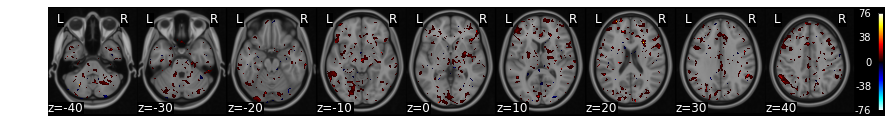

In [141]:
s = Brain_Data(b)
ss = s.ttest(threshold_dict={'unc':.05})
f = ss['thr_t'].plot()